# GIT: A Generative Image-to-text Transformer for Vision and Language

Design and train a Generative Image-to-text Transformer, GIT, to unify
vision-language tasks such as image/video captioning and question answering. While genera-
tive models provide a consistent network architecture between pre-training and fine-tuning,
existing work typically contains complex structures (uni/multi-modal encoder/decoder) and
depends on external modules such as object detectors/taggers and optical character recogni-
tion (OCR). In GIT, simplify the architecture as one image encoder and one text decoder
under a single language modeling task. Also scale up the pre-training data and the model
size to boost the model performance. Without bells and whistles, our GIT establishes new
state of the arts on numerous challenging benchmarks with a large margin. For instance, our
model surpasses the human performance for the first time on TextCaps (138.2 vs. 125.5 in
CIDEr). Furthermore, present a new scheme of generation-based image classification and
scene text recognition, achieving decent performance on standard benchmarks.

* Paper: https://arxiv.org/abs/2205.14100 
* Code: https://github.com/microsoft/GenerativeImage2Text

# Radiology Objects in COntext (ROCO): A Multimodal Image Dataset
Radiology Objects in COntext (ROCO) dataset, a large-scale medical and multimodal imaging dataset. The listed images are from publications available on the PubMed Central Open Access FTP mirror, which were automatically detected as non-compound and either radiology or non-radiology. Each image is distributed as a download link, together with its caption. Additionally, keywords extracted from the image caption, as well as the corresponding UMLS Semantic Types (SemTypes) and UMLS Concept Unique Identifiers (CUIs) are available. The dataset could be used to build generative models for image captioning, classification models for image categorization and tagging or content-based image retrieval systems.

* Dataset: https://github.com/razorx89/roco-dataset

# Caption Generation from Chest X-Ray Images:


![https://ibb.co/DYS1tS3](https://i.ibb.co/G9bd0bg/chest-Xray.png)

3. Task : Fine tune two ML Models with a custom dataset using the following transformers to
generate description of a chest x-ray image.
4. Base Models: The base transformers models to be used for fine tuning :
* Salesforce/blip-image-captioning-large
* microsoft/git-large-textcaps
5. Dataset : Radiology Objects in COntext (ROCO): A Multimodal Image Dataset
* Link : https://www.kaggle.com/datasets/virajbagal/roco-dataset
* Filter to select only chest x-ray images in the ‘radiology’ folder. You can extract
those images and their corresponding captions using search for the following string
in the ‘captions’ file: "chest x-ray"
* Train:
* Select ~1800 images
* Test and Validation :
* Select ~200 images
6. Directions:
* Create two training Jupyter Notebooks containing finetune scripts and evaluation
results for two captioning models above.
* Fine tune and evaluate the model you will save. Explain the steps you followed and
show the several predictions to see the quality of the models you trained.
* Deploy your model for prediction on a simple web page using Gradio or Streamlit or
Fast API or in a container you will build. You will share the urls of your deployed
models with us during the second technical interview; so that we will have a chance
to get predictions from your models using several images.

In [1]:
# Install latest version of the library
!pip install -q datasets==2.13.1

In [2]:
# Import important libraries
import pandas as pd
from datasets import load_dataset 
import transformers
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('/kaggle/input/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = 'radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [5]:
# Display first 5 columns of dataframe
df_train.head()

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...


In [6]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

,id,name,caption
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ..."
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ..."
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...


In [7]:
# Create "images" column to create full path for images
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']
filtered_df.head()

/tmp/ipykernel_32/1067852196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']


,id,name,caption,images
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",/kaggle/input/roco-dataset/all_data/train/radi...
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,/kaggle/input/roco-dataset/all_data/train/radi...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",/kaggle/input/roco-dataset/all_data/train/radi...
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,/kaggle/input/roco-dataset/all_data/train/radi...
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...,/kaggle/input/roco-dataset/all_data/train/radi...


In [9]:
# Create new directory for training images
folder_path = "/kaggle/working/train"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [10]:
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

In [14]:
# Delete extra column from the dataframe
filtered_df = filtered_df.drop(columns=["images", "id"])

KeyError: "['images', 'id'] not found in axis"

In [15]:
# Convert dataframe to json format
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()

In [17]:
# Save data to json file
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))

In [18]:
# Load dataset for training
dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
dataset

Resolving data files:   0%|          | 0/1736 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-f53c37b819093ff2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'text'],
    num_rows: 1735
})

 The girl: chest X-ray film, done after admission to hospital, showing increasing bilateral infiltrations of the lung, done after admission.



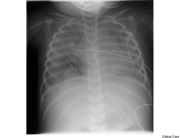

In [20]:
# Visualize the first images and its caption from training data
example = dataset[0]
image = example["image"]
width, height = image.size
print(example["text"])
display(image.resize((int(0.3*width), int(0.3*height))))

**Create PyTorch Dataset**

Next, we create a standard PyTorch dataset. Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use GitProcessor to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into input_ids and attention_mask, and the image gets turned into pixel_values.


In [21]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [22]:
processor = AutoProcessor.from_pretrained("microsoft/git-large-textcaps")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-textcaps")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [25]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [26]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [28]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [29]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.2234, grad_fn=<NllLossBackward0>)

In [32]:
%%time
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    #print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
  print("Loss:", loss.item())

Epoch: 0


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/magics/execution.py:1325 in time            │
│                                                                                                  │
│   1322 │   │   else:                                                                             │
│   1323 │   │   │   st = clock2()                                                                 │
│   1324 │   │   │   try:                                                                          │
│ ❱ 1325 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1326 │   │   │   │   out=None                                                                  │
│   1327 │   │   │   │   # multi-line %%time case                                                  │
│   1328 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:11                                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [34]:
#### Create save model path and save the trained model
saved_folder_path = "/kaggle/working/saved_model"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)

model.save_pretrained(saved_folder_path)
processor.save_pretrained(saved_folder_path)

In [35]:
### Load the trained model
load_model = AutoModelForCausalLM.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

In [36]:
# Creating Test Dataset

df_test = pd.read_csv('/kaggle/input/roco-dataset/all_data/test/radiology/testdata.csv', delimiter=',')
mask = df_test['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_test[mask]
filtered_df.head()
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']
filtered_df.head()
folder_path = "/kaggle/working/test"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

filtered_df = filtered_df.drop(columns=["images", "id"])
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()
# add metadata.jsonl file to this folder
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))
test_dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
test_dataset

/tmp/ipykernel_32/3653442878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']


Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-16004772f055717b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'text'],
    num_rows: 199
})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │                                                                                           │
│   10 │   generated_ids = model.generate(pixel_values=pixel_values, max_length=50)                │
│   11 │   generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[    │
│ ❱ 12 │   fig.add_subplot(2, 2, i+1)  # Change the size of the grid to 4x4                        │
│   13 │   plt.imshow(image)                                                                       │
│   14 │   plt.axis("off")                                                                         │
│   15 │   plt.title(f"Generated caption: {generated_caption}")                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/matplotlib/figure.py:768 in add_subplot                  │
│                                                                                                  │
│    765 │   │   │   │   args = tuple(map(int, str(args[0])))                                      │
│    766 │   │   │   projection_class, pkw = self._process_projection_requirements(                │
│    767 │   │   │   │   *args, **kwargs)                                                          │
│ ❱  768 │   │   │   ax = projection_class(self, *args, **pkw)                                     │
│    769 │   │   │   key = (projection_class, pkw)                                                 │
│    770 │   │   return self._add_axes_internal(ax, key)                                           │
│    771                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/matplotlib/axes/_base.py:644 in __init__                 │
│                                                                                                  │
│    641 │   │   │   self._position = mtransforms.Bbox.from_bounds(*args[0])                       │
│    642 │   │   else:                                                                             │
│    643 │   │   │   self._position = self._originalPosition = mtransforms.Bbox.unit()             │
│ ❱  644 │   │   │   subplotspec = SubplotSpec._from_subplot_args(fig, args)                       │
│    645 │   │   if self._position.width < 0 or self._position.height < 0:                         │
│    646 │   │   │   raise ValueError('Width and height specified must be non-negative')           │
│    647 │   │   self._originalPosition = self._position.froz

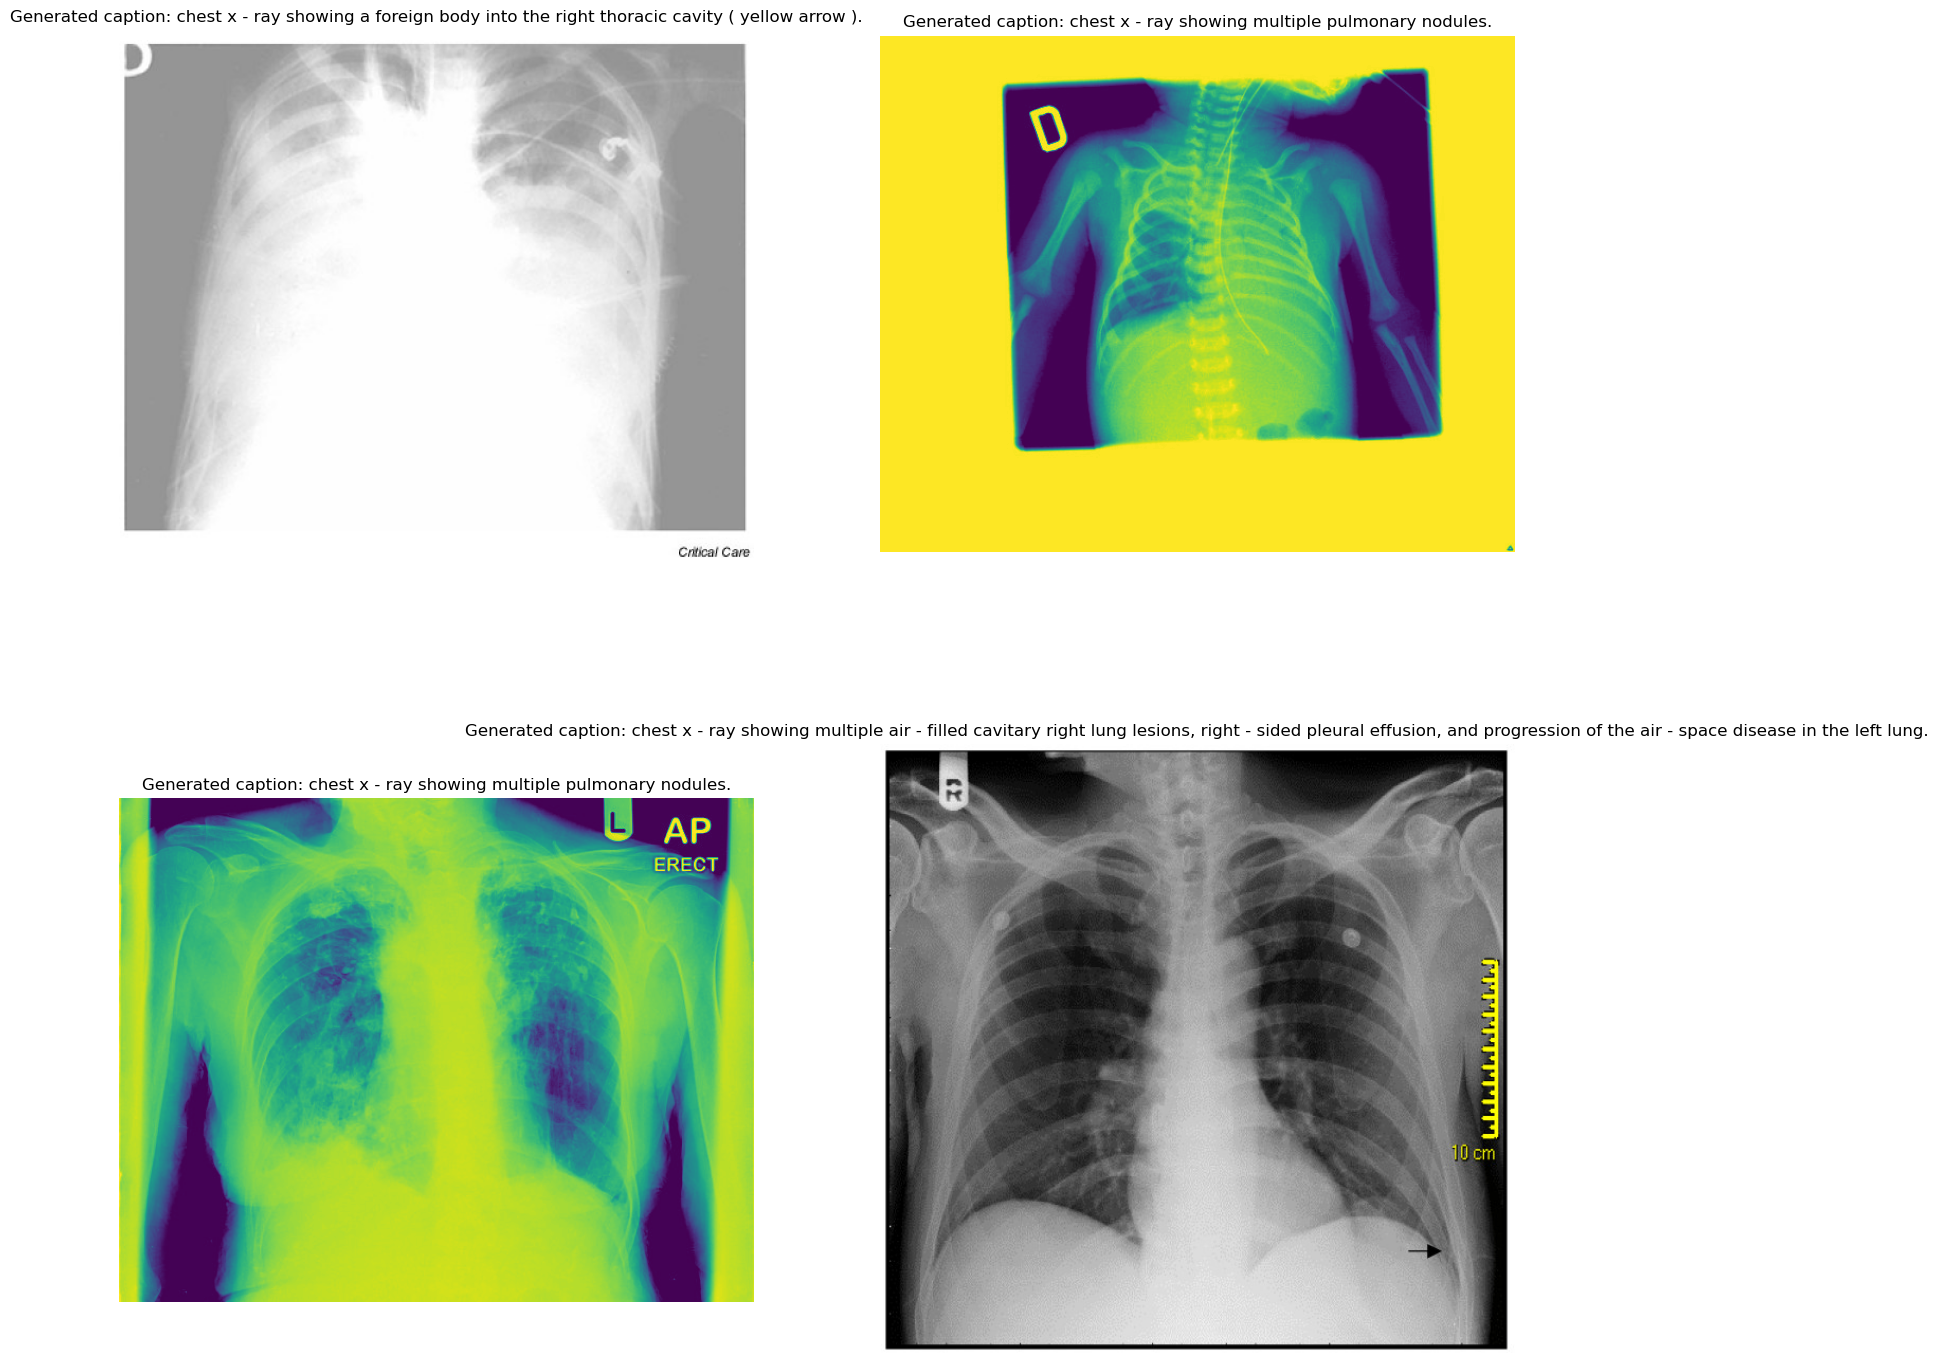

In [40]:
# Predict 16 images of Test Data from trained model
fig = plt.figure(figsize=(18, 18))  # Increase the size of the figure to accommodate 4x4 subplots

# prepare image for the model
for i, example in enumerate(test_dataset):
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    fig.add_subplot(2, 2, i+1)  # Change the size of the grid to 4x4
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Generated caption: {generated_caption}")
    
    if i == 15:  # Display 199 images
        break

plt.show()  # Show the plot after all subplots are added

# Deploy Model with Gradio:

In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr
from PIL import Image

In [ ]:
processor = AutoProcessor.from_pretrained(saved_folder_path)
model = AutoModelForCausalLM.from_pretrained(saved_folder_path)

In [ ]:
# Define the prediction function
def generate_caption(image):
    # Process the image
    image = Image.fromarray(image)
    #inputs = tokenizer(image, return_tensors="pt")
    inputs = processor(images=image, return_tensors="pt")#.to(device)
    pixel_values = inputs.pixel_values

    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_caption

In [ ]:
# Define the Gradio interface
interface = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    live=True
)

In [ ]:
# Launch the Gradio interface
interface.launch()

In [ ]:
print("Thanks")